In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math

configuration = tflscripts.read_configuration()

In [5]:
datasets_and_devices = [
    ['synergy-final-iter1', '128.237.254.195'],
    ['synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134'],
    ['scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127'],
    ['robotics-final', '128.237.247.134']
]

complete_df = []
for dataset, device in datasets_and_devices:
    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')

    complete_df.append(df)

complete_df = pd.concat(complete_df)
complete_df = complete_df.reset_index()

In [67]:
def average_values(df, window_size=5):
    history = []
    averaged_df = []
    for row in df.values:
        history.append(row)
        if len(history) > window_size:
            history.pop(0)
        averaged_df.append(np.mean(history, axis=0))

    averaged_df = pd.DataFrame(averaged_df)
    averaged_df.columns = df.columns
    averaged_df.index = df.index
    return averaged_df

In [13]:
def read_dataset_by_activation_groups(dataset, device, activities, complete_df):
    anomaly_percentile = 50

    sensor_channels_percentiles = {
        'MICROPHONE_fft': 50,
#         'MICROPHONE_sst': 10,
        'ACCEL_fft': 10,
#         'ACCEL_sst': 10,
#         'EMI': 10,
#         'MAGNETO': 10,
#         'GEYE': 10,
#         'COLOR': 10,
#         'TEMPERATURE': 10,
#         'IRMOTION': 10,
#         'RSSI': 10,
#         'HUMIDITY': 10,
#         'BAROMETER': 10
    }
    sensor_channels = np.sort([c for c in sensor_channels_percentiles])

    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')

#     null_df = df.loc[df.label == configuration['activities'].index('Null')]

    activities_i = [configuration['activities'].index(a) for a in activities]
    df = df.loc[df.label.isin(activities_i)]

    value_columns = df.filter(regex='|'.join(sensor_channels)).columns
    mean = complete_df[value_columns].mean()
    std = complete_df[value_columns].std()
    df[value_columns] = (df[value_columns] - mean) / std
    df = df.replace([np.inf, -np.inf], np.nan)

    anomalies_df = {}

    for channel in sensor_channels:
        value_columns = df.filter(regex=channel).columns

        anomalies = (df[value_columns] ** 2).sum(axis=1).apply(np.sqrt)
        anomalies_df[channel] = anomalies

    anomalies_df = pd.DataFrame(anomalies_df)
    anomalies_df = anomalies_df.sort_index(axis=1)

    for column in anomalies_df.columns:
        percentile = sensor_channels_percentiles[column]
        threshold = np.percentile(anomalies_df[column].values, 100 - percentile)
        anomalies_df[column] = [x > threshold for x in anomalies_df[column]]

    anomalies_df['signature'] = [';'.join([str(x) for x in row]) for row in anomalies_df.values]

    datasets_by_signature = {}

    for signature in anomalies_df['signature'].unique():
        column_presence = [presence == 'True' for presence in signature.split(';')]
        columns = [col for i, col in enumerate(sensor_channels) if column_presence[i]]
        if len(columns) == 0:
            continue

        subdf = df.loc[anomalies_df.signature == signature]
        y = subdf.label
        x = subdf.filter(regex='|'.join(columns))

        if len(y) > 0:
            datasets_by_signature[signature] = [x, y]

    return datasets_by_signature

In [14]:
class CustomPipeline:
    def __init__(self, steps):
        self.steps = steps
        self.single_class = None

    def fit(self, x, y):
        if len(np.unique(y)) > 1:
            self.ppl = Pipeline(self.steps)
            self.ppl.fit(x, y)
        else:
            self.single_class = np.unique(y)[0]

    def predict(self, x):
        if self.single_class is not None:
            return [self.single_class for _ in np.array(x)]
        else:
            return self.ppl.predict(x)

activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]
    
anomaly_percentile = 50

# source_device = '128.237.254.195'
# source_dataset = 'synergy-final-iter1'
target_device = '128.237.248.186'
target_dataset = 'synergy-final-iter2'
# source_device = '128.237.248.186'
# source_dataset = 'scott-final-iter1'
# target_device = '128.237.246.127'
# target_dataset = 'scott-final-iter1'

sources = [
#     ['128.237.248.186', 'scott-final-iter1'],
#     ['128.237.248.186', 'synergy-final-iter2'],
#     ['128.237.246.127', 'robotics-final'],
    ['128.237.254.195', 'synergy-final-iter1']
]

source_datasets_by_signature = {}
for source in sources:
    datasets = read_dataset_by_activation_groups(dataset=source[1],
                                                 device=source[0],
                                                 complete_df=complete_df,
                                                 activities=activities)
    
    for signature in datasets:
        if signature in source_datasets_by_signature:
            source_datasets_by_signature[signature] = [
                pd.concat([source_datasets_by_signature[signature][0], datasets[signature][0]]),
                pd.concat([source_datasets_by_signature[signature][1], datasets[signature][1]]),
            ]
        else:
            source_datasets_by_signature[signature] = datasets[signature]

target_datasets_by_signature = read_dataset_by_activation_groups(dataset=target_dataset,
                                                                 device=target_device,
                                                                 complete_df=complete_df,
                                                                 activities=activities)

pipelines = {}

for signature in source_datasets_by_signature:
    ppl = CustomPipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
    ])
    x, y = source_datasets_by_signature[signature]
    ppl.fit(x, y)

    pipelines[signature] = ppl

dfs_y = []

for signature in target_datasets_by_signature:
    x, y = target_datasets_by_signature[signature]

    if signature in pipelines:
        ppl = pipelines[signature]
        predicted = ppl.predict(x)

        df_y = pd.DataFrame(y)
        df_y['predicted'] = predicted
        dfs_y.append(df_y)
        print(accuracy_score(y, predicted))

df_y = pd.concat(dfs_y, axis=0)
print('Final', accuracy_score(df_y.label, df_y.predicted))

0.585795824001
0.504373177843
0.098144823459
Final 0.53091684435


In [28]:
x_train, y_train = get_dataset_and_filter_outliers('128.237.254.195', 'synergy-final-iter1')
x_test, y_test = get_dataset_and_filter_outliers('128.237.248.186', 'synergy-final-iter2')

ppl = Pipeline([
    ('impute', Imputer()),
#     ('clf', OneVsRestClassifier(RandomForestClassifier()))
    ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
#     ('clf', LogisticRegression())
])

ppl.fit(x_train, y_train)

predicted = ppl.predict(x_test)
accuracy_score(y_test, predicted)

0.238625

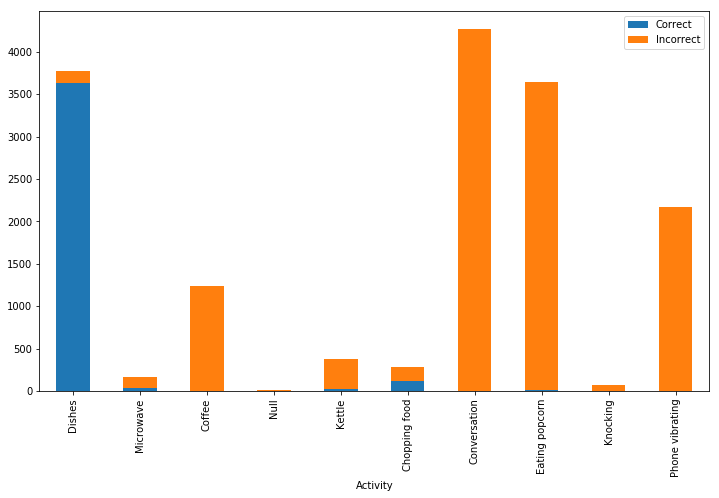

In [29]:
results = []
configuration = tflscripts.read_configuration()
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])
results = pd.DataFrame(results)
results.columns = ['Activity', 'Correct', 'Incorrect']
results = results.set_index('Activity')
results.plot.bar(stacked=True)

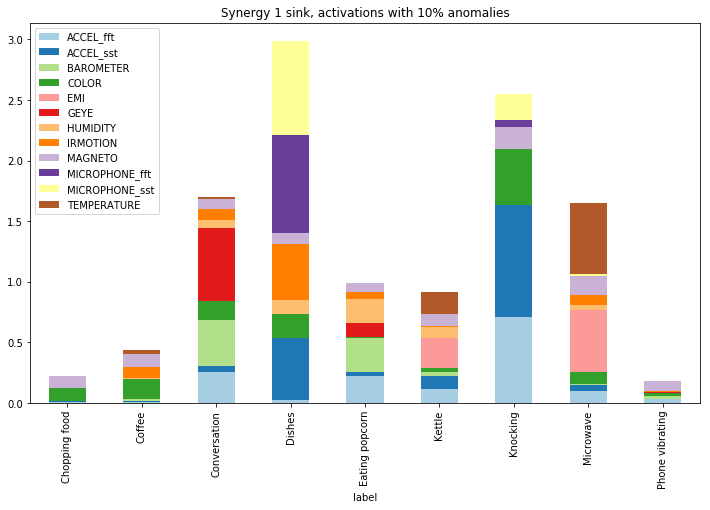

In [72]:
device = '128.237.248.186'
dataset = 'synergy-final-iter2'

activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

sensor_channels_percentiles = {
    'MICROPHONE_fft': 10,
    'MICROPHONE_sst': 10,
    'ACCEL_fft': 10,
    'ACCEL_sst': 10,
    'EMI': 10,
    'MAGNETO': 10,
    'GEYE': 10,
    'COLOR': 10,
    'TEMPERATURE': 10,
    'IRMOTION': 10,
#     'RSSI': 10,
    'HUMIDITY': 10,
    'BAROMETER': 10
}
sensor_channels = np.sort([c for c in sensor_channels_percentiles])

dataset_path = '../datasets/' + dataset + '-complete/'
df = pd.read_pickle(dataset_path + device + '.p')
df = average_values(df)

#     null_df = df.loc[df.label == configuration['activities'].index('Null')]

activities_i = [configuration['activities'].index(a) for a in activities]
df = df.loc[df.label.isin(activities_i)]

value_columns = df.filter(regex='|'.join(sensor_channels)).columns
mean = complete_df[value_columns].mean()
std = complete_df[value_columns].std()
df[value_columns] = (df[value_columns] - mean) / std
df = df.replace([np.inf, -np.inf], np.nan)

anomalies_df = {}

for channel in sensor_channels:
    value_columns = df.filter(regex=channel).columns

    anomalies = (df[value_columns] ** 2).sum(axis=1).apply(np.sqrt)
    anomalies_df[channel] = anomalies

anomalies_df = pd.DataFrame(anomalies_df)
anomalies_df = anomalies_df.sort_index(axis=1)

for column in anomalies_df.columns:
    percentile = sensor_channels_percentiles[column]
    threshold = np.percentile(anomalies_df[column].values, 100 - percentile)
    anomalies_df[column] = [1 if x > threshold else 0 for x in anomalies_df[column]]

labels = [configuration['activities'][int(i)] for i in df.label]
anomalies_df['label'] = labels
    
anomalies_df.groupby('label').mean().plot.bar(stacked=True, colormap='Paired')
plt.title('Synergy 1 sink, activations with 10% anomalies')